In [678]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)

#Tensorflow
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#Pandas
import pandas as pd 

#Keras
import keras
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Statistics Libraries
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
from scipy import interp
import math as m
from itertools import cycle

#plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

#OverSampling
from imblearn.over_sampling import RandomOverSampler

#SKlearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#global
import tempfile
import os, glob

import warnings
warnings.filterwarnings("ignore")

In [679]:
datasource_path = os.path.join(os.getcwd(), r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ', os.path.basename(file))

0   3C-EURUSD_FULL_1D_145F.csv
1   3C-EURUSD_FULL_1D_145F_0.0017Sep.csv
2   3C-EURUSD_FULL_1D_145F_0.0018Sep.csv
3   3C-EURUSD_FULL_1D_145F_0.0019Sep.csv
4   3C-EURUSD_FULL_1D_145F_0.0025Sep.csv
5   3C-EURUSD_FULL_1D_145F_0.0028Sep.csv
6   3C-EURUSD_FULL_1D_145F_0.0029Sep.csv
7   3C-EURUSD_FULL_1D_145F_0.002Sep.csv
8   3C-EURUSD_FULL_1D_145F_0.0032Sep.csv
9   3C-EURUSD_FULL_1D_145F_0.0035Sep.csv
10   3C-EURUSD_FULL_1D_145F_0.003Sep.csv
11   3C-EURUSD_FULL_1D_21F.csv
12   3C-EURUSD_FULL_1D_45F.csv
13   3C-EURUSD_FULL_1D_45F_0.0029Sep.csv
14   3C-EURUSD_FULL_1D_70F.csv
15   3C-EURUSD_FULL_1D_70F_0.0029Sep.csv
16   3C-EURUSD_FULL_1H_45F.csv
17   5C-EURUSD_FULL_1D_21F.csv
18   5C-EURUSD_FULL_1D_27F.csv
19   5C-EURUSD_FULL_1D_45F.csv
20   5C-EURUSD_FULL_1D_70F.csv
21   C-EURUSD_FULL_1D_21F.csv
22   C-EURUSD_FULL_1H_25F.csv
23   C-EURUSD_FULL_1H_45F.csv
24   C-EURUSD_FULL_1H_54F.csv


In [680]:
#SELECT an INDEX 
INDX = 7

CLASS_NUMBER = '3C'
MODEL_TYPE = 'RNN'
FRECUENCIA = '1D'
TARGET_NAME = "Class"
ID = '01'

RANGE = 11  #Profundidad

EPOCHS = 1000
BATCH_SIZE = 32#2048
TEST_SIZE = .20
VAL_SIZE = .20


In [681]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[INDX], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
NUM_FEATURES = DATASET.shape[1]
DATASET.head(2)

,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr,Class
0,2004-01-01,1.25950,1.26052,1.24698,1.25733,4.621817e+05,1.25934,1.26035,1.24679,1.25723,...,76.440177,76.440177,-23.559823,0.0,1.257330,0.0,-0.522913,0.000000,0.000000,0.0
1,2004-01-02,1.25717,1.26282,1.25214,1.25832,1.066578e+06,1.25701,1.26263,1.25198,1.25806,...,71.590909,74.015543,-28.409091,0.0,1.257865,0.0,0.078738,0.078707,0.078738,1.0


In [682]:
SIZE = DATASET.shape[0]
SIZE

5137

In [683]:
#LOCATION TO SAVE
pwd = os.getcwd()
source_data_toSave = os.path.join(pwd, r'../../../Models/2020/LSTM/')
#print('Location to Save: ', source_data)
FILENAME = CLASS_NUMBER + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + str(SIZE) + 'Size_' + MODEL_TYPE + '_' + str(RANGE) + 'Range_' + str(EPOCHS) + 'Epochs' + '_' + TARGET_NAME + "_"+ ID 
file_name_toSave = FILENAME + '.hdf5'
print('FILENAME: ', FILENAME)
print('File Name Model:', file_name_toSave)


FILENAME:  3C_1D_145F_5137Size_RNN_11Range_1000Epochs_Class_01
File Name Model: 3C_1D_145F_5137Size_RNN_11Range_1000Epochs_Class_01.hdf5


In [684]:
testVal_results_csv = os.path.join(pwd, r'../../../Results/RNN/' + FILENAME + '_TestVal.csv')
print(testVal_results_csv)
test_results_csv = os.path.join(pwd, r'../../../Results/RNN/' + FILENAME + '_Test.csv')
print(test_results_csv)
train_results_csv = os.path.join(pwd, r'../../../Results/RNN/' + FILENAME + '_Train.csv')
print(train_results_csv)

C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/RNN/3C_1D_145F_5137Size_RNN_11Range_1000Epochs_Class_01_TestVal.csv
C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/RNN/3C_1D_145F_5137Size_RNN_11Range_1000Epochs_Class_01_Test.csv
C:\Users\maw\Documents\ITESO\forex_prediction\Jupyter Notebooks\IDI4\models_clasification\../../../Results/RNN/3C_1D_145F_5137Size_RNN_11Range_1000Epochs_Class_01_Train.csv


In [685]:
HYPER_L1_IN = RANGE

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [686]:
DATASET.columns

Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Bid',
       'High_Bid', 'Low_Bid', 'Close_Bid',
       ...
       'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr', 'momentum_ao',
       'momentum_kama', 'momentum_roc', 'others_dr', 'others_dlr', 'others_cr',
       'Class'],
      dtype='object', length=145)

In [687]:
REVOME_FEATURES = True
# In base of XGBoost Feature Analisis I'll remove some features from the 145 original dataset.
#Describe DATASET
if (REVOME_FEATURES):
    print('Shape: ', DATASET.shape)
    print(DATASET.describe())
    DATASET = DATASET.drop(['MACD_5_25'], axis = 1)
    DATASET = DATASET.drop(['momentum_roc'], axis = 1)
    DATASET = DATASET.drop(['trend_mass_index'], axis = 1)
    DATASET = DATASET.drop(['trend_aroon_ind'], axis = 1)
    DATASET = DATASET.drop(['trend_visual_ichimoku_a'], axis = 1)
    DATASET = DATASET.drop(['AQM_Pct_Range_Close'], axis = 1)
    DATASET = DATASET.drop(['trend_kst'], axis = 1)
    DATASET = DATASET.drop(['MACDsign_5_25'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_150'], axis = 1)
    DATASET = DATASET.drop(['rsi_25'], axis = 1)
    DATASET = DATASET.drop(['trend_macd'], axis = 1)
    #DATASET = DATASET.drop(['High'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_200'], axis = 1)
    DATASET = DATASET.drop(['volatility_bbl'], axis = 1)
    DATASET = DATASET.drop(['volatility_bbh'], axis = 1)
    DATASET = DATASET.drop(['Bollinger_Low'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_5'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_25'], axis = 1)
    #DATASET = DATASET.drop(['Low'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_down'], axis = 1)
    DATASET = DATASET.drop(['momentum_tsi'], axis = 1)
    DATASET = DATASET.drop(['MA_Close_175'], axis = 1)
    DATASET = DATASET.drop(['trend_macd_signal'], axis = 1)
    DATASET = DATASET.drop(['trend_visual_ichimoku_b'], axis = 1)
    DATASET = DATASET.drop(['Bollinger_High'], axis = 1)
    #DATASET = DATASET.drop(['Close'], axis = 1)
    DATASET = DATASET.drop(['momentum_rsi'], axis = 1)
    DATASET = DATASET.drop(['volatility_kcc'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_up'], axis = 1)
    DATASET = DATASET.drop(['others_dr'], axis = 1)
    DATASET = DATASET.drop(['volume_vwap'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_down_indicator'], axis = 1)
    DATASET = DATASET.drop(['trend_ema_slow'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_a'], axis = 1)
    DATASET = DATASET.drop(['trend_ema_fast'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_base'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_b'], axis = 1)
    DATASET = DATASET.drop(['trend_ichimoku_conv'], axis = 1)
    DATASET = DATASET.drop(['volatility_kch'], axis = 1)
    DATASET = DATASET.drop(['volatility_dcl'], axis = 1)
    DATASET = DATASET.drop(['momentum_kama'], axis = 1)
    DATASET = DATASET.drop(['trend_trix'], axis = 1)
    DATASET = DATASET.drop(['EMA_Close_5'], axis = 1)
    DATASET = DATASET.drop(['trend_sma_fast'], axis = 1)
    DATASET = DATASET.drop(['volatility_dcm'], axis = 1)
    DATASET = DATASET.drop(['trend_psar_up_indicator'], axis = 1)
    DATASET = DATASET.drop(['volatility_dch'], axis = 1)
    DATASET = DATASET.drop(['volatility_bbm'], axis = 1)
    DATASET = DATASET.drop(['trend_sma_slow'], axis = 1)
    DATASET = DATASET.drop(['volatility_kcl'], axis = 1)
    DATASET = DATASET.drop(['Rolling_Mean25'], axis = 1)



Shape:  (5137, 145)
              Open         High          Low        Close        Volume  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03   
mean      1.263948     1.268773     1.259111     1.263939  4.156849e+05   
std       0.122827     0.123592     0.121990     0.122823  4.429918e+05   
min       1.039090     1.041820     1.034050     1.039090  5.400000e+01   
25%       1.149190     1.153490     1.145380     1.149120  1.159636e+05   
50%       1.270260     1.275990     1.265560     1.270260  2.200810e+05   
75%       1.350610     1.355180     1.345920     1.350700  7.439951e+05   
max       1.597400     1.604030     1.589800     1.597370  2.237468e+06   

          Open_Bid     High_Bid      Low_Bid    Close_Bid    Volume_Bid  ...  \
count  5137.000000  5137.000000  5137.000000  5137.000000  5.137000e+03  ...   
mean      1.263810     1.268680     1.259015     1.263822  4.616911e+05  ...   
std       0.122817     0.123571     0.121969     0.122813  5.305

In [688]:
print(DATASET.shape)

(5137, 97)


In [689]:

print(DATASET.shape)
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.shape)


(5137, 97)
(5137, 95)


In [690]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(4938, 95)
      Open     High      Low    Close        Volume  Open_Bid  High_Bid  \
0  1.23655  1.23817  1.22801  1.23179  1.078729e+06   1.23639   1.23804   
1  1.23158  1.23241  1.22967  1.23109  8.212280e+04   1.23088   1.23231   
2  1.23140  1.23154  1.21310  1.21496  1.130388e+06   1.23124   1.23140   
3  1.21495  1.21669  1.20594  1.20711  1.123270e+06   1.21479   1.21656   
4  1.20718  1.21160  1.20519  1.20794  1.118725e+06   1.20702   1.21156   

   Low_Bid  Close_Bid   Volume_Bid  ...  trend_aroon_up  trend_aroon_down  \
0  1.22791    1.23169  1291823.750  ...            76.0              28.0   
1  1.22955    1.23099    93508.000  ...            72.0              24.0   
2  1.21298    1.21486  1348137.000  ...            68.0              20.0   
3  1.20583    1.20701  1344214.000  ...            64.0              16.0   
4  1.20504    1.20784  1355827.375  ...            60.0              12.0   

   momentum_uo  momentum_stoch  momentum_stoch_signal  momentum_wr  \
0    

In [691]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  4938
Start:  0


In [692]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc

print(DF_Full.shape)

(4938, 95)


In [693]:

total = DATASET.shape[0]
print('Total: ', total)

Total:  5137


In [694]:
DF_Full[TARGET_NAME][0:12]

0     0.0
1    -1.0
2    -1.0
3     0.0
4     1.0
5    -1.0
6     0.0
7     1.0
8     1.0
9     0.0
10    0.0
11   -1.0
Name: Class, dtype: float64

### Generate VECTOR Y

In [695]:
#generate the VECTOR Y
DF_Y = DF_Full[TARGET_NAME]
uniques, ids = np.unique(DF_Full[TARGET_NAME], return_inverse=True)

#target_y = np_utils.to_categorical(DF_Full[TARGET_NAME],num_classes=5)
target_y = np_utils.to_categorical(ids,len(uniques))
print(ids)
print(uniques)
print(target_y)

[1 0 0 ... 2 1 1]
[-1.  0.  1.]
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [696]:
close_y = target_y
print(close_y[:10])   
#   [1. 0. 0. 0. 0.]   =  0
#   [0. 1. 0. 0. 0.]   =  1
#   [0. 0. 1. 0. 0.]   =   2 
#   [0. 0. 0. 1. 0.]   =  -2
#   [0. 0. 0. 0. 1.]   =  -1
close_y.shape

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


(4938, 3)

### REMOVE COLUMNS 

In [697]:
#REMOVE CLASS FROM Data
print(DF_Full.shape)
DF_Full = DF_Full.drop(['Class'], axis = 1)
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
DF_Full.head()

(4938, 95)
(4938, 94)


,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,...,trend_kst_diff,trend_aroon_up,trend_aroon_down,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dlr,others_cr
0,1.23655,1.23817,1.22801,1.23179,1.078729e+06,1.23639,1.23804,1.22791,1.23169,1291823.750,...,8.132749,76.0,28.0,64.759073,81.313269,88.120556,-18.686731,0.010763,-0.368701,-2.031289
1,1.23158,1.23241,1.22967,1.23109,8.212280e+04,1.23088,1.23231,1.22955,1.23099,93508.000,...,7.361159,72.0,24.0,56.013733,77.982456,84.601906,-22.017544,0.010124,-0.056844,-2.086962
2,1.23140,1.23154,1.21310,1.21496,1.130388e+06,1.23124,1.23140,1.21298,1.21486,1348137.000,...,5.575709,68.0,20.0,43.726020,7.288401,55.528042,-92.711599,0.008048,-1.318880,-3.369839
3,1.21495,1.21669,1.20594,1.20711,1.123270e+06,1.21479,1.21656,1.20583,1.20701,1344214.000,...,3.034464,64.0,16.0,38.351979,3.580171,29.617010,-96.419829,0.004506,-0.648208,-3.994178
4,1.20718,1.21160,1.20519,1.20794,1.118725e+06,1.20702,1.21156,1.20504,1.20784,1355827.375,...,0.230380,60.0,12.0,38.098091,8.226144,6.364906,-91.773856,-0.000011,0.068736,-3.928165


In [698]:
def get_2Dimension(df, RANGE):
    new_df = pd.DataFrame()
    for i in range(RANGE):
#        new_df = df
        for j in range (df.shape[1]):
            #value = df.iloc[i+1,j]
            #print(value)
            new_col_name = df.columns[j] + '_' + str(i+1)
            #print(new_col_name)
            new_df[new_col_name] = df.iloc[i+1:,j]
            #print(new_df[new_col_name].isnull().sum())
            new_df.fillna(method='backfill', inplace=True)
            #print(new_df[new_col_name].isnull().sum())
    print(new_df.columns)
    return new_df


In [699]:
dataframe_plane = get_2Dimension(DF_Full,RANGE)
dataframe_plane.shape

Index(['Open_1', 'High_1', 'Low_1', 'Close_1', 'Volume_1', 'Open_Bid_1',
       'High_Bid_1', 'Low_Bid_1', 'Close_Bid_1', 'Volume_Bid_1',
       ...
       'trend_kst_diff_11', 'trend_aroon_up_11', 'trend_aroon_down_11',
       'momentum_uo_11', 'momentum_stoch_11', 'momentum_stoch_signal_11',
       'momentum_wr_11', 'momentum_ao_11', 'others_dlr_11', 'others_cr_11'],
      dtype='object', length=1034)


(4937, 1034)

In [700]:
DF_Full = pd.concat([DF_Full, dataframe_plane], axis=1, sort=False)
DF_Full.fillna(method='backfill', inplace=True)
DF_Full.shape

(4938, 1128)

In [701]:
DF_Full.head(3)

,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,...,trend_kst_diff_11,trend_aroon_up_11,trend_aroon_down_11,momentum_uo_11,momentum_stoch_11,momentum_stoch_signal_11,momentum_wr_11,momentum_ao_11,others_dlr_11,others_cr_11
0,1.23655,1.23817,1.22801,1.23179,1.078729e+06,1.23639,1.23804,1.22791,1.23169,1291823.75,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632
1,1.23158,1.23241,1.22967,1.23109,8.212280e+04,1.23088,1.23231,1.22955,1.23099,93508.00,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632
2,1.23140,1.23154,1.21310,1.21496,1.130388e+06,1.23124,1.23140,1.21298,1.21486,1348137.00,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632


In [702]:
# Convert categorical columns to dummy columns
dummy_columns = list(DF_Full.dtypes[DF_Full.dtypes == 'category'].index)
DF_Full = pd.get_dummies(DF_Full, columns=dummy_columns)

In [703]:
# Preview the data
DF_Full.head()

,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,...,trend_kst_diff_11,trend_aroon_up_11,trend_aroon_down_11,momentum_uo_11,momentum_stoch_11,momentum_stoch_signal_11,momentum_wr_11,momentum_ao_11,others_dlr_11,others_cr_11
0,1.23655,1.23817,1.22801,1.23179,1.078729e+06,1.23639,1.23804,1.22791,1.23169,1291823.750,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632
1,1.23158,1.23241,1.22967,1.23109,8.212280e+04,1.23088,1.23231,1.22955,1.23099,93508.000,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632
2,1.23140,1.23154,1.21310,1.21496,1.130388e+06,1.23124,1.23140,1.21298,1.21486,1348137.000,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632
3,1.21495,1.21669,1.20594,1.20711,1.123270e+06,1.21479,1.21656,1.20583,1.20701,1344214.000,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632
4,1.20718,1.21160,1.20519,1.20794,1.118725e+06,1.20702,1.21156,1.20504,1.20784,1355827.375,...,-6.766878,32.0,84.0,53.806744,45.640637,48.088775,-54.359363,-0.00684,-0.183121,-3.234632


### SPLIT in 3 Sub Datasets

In [704]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)

end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.4
count of Val and Test: 2054
end of train:  3083
count val:  1027
count test:  1027
end_val 4110


In [705]:
close_y[:end_train,:]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [706]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y[:end_train,:]
data_val_y = close_y[end_train: end_val,:]
data_test_y = close_y[end_val:,:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (3083, 1128)
data_val.shape:  (1027, 1128)
data_test.shape:  (828, 1128)
data_training_y.shape:  (3083, 3)
data_val_y.shape:  (1027, 3)
data_test_y.shape:  (828, 3)


In [707]:
x_train = data_training
x_test = data_val
y_train = data_training_y
y_test = data_val_y

x_rtest = data_test
y_rtest = data_test_y

In [708]:
uniques_data_test_y = uniques[data_test_y.argmax(1)]
uniques_data_test_y[:10]

array([ 0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  1.])

### SCALAR

In [709]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.16128208 0.15335663 0.14996946 ... 0.4556722  0.41403261 0.11512179]
 [0.14973038 0.14002731 0.15386965 ... 0.4556722  0.41403261 0.11512179]
 [0.14931201 0.13801402 0.11493821 ... 0.4556722  0.41403261 0.11512179]
 ...
 [0.44619282 0.43845602 0.45402002 ... 0.47604876 0.45440868 0.44837765]
 [0.44830792 0.44174207 0.45622856 ... 0.48041045 0.45035521 0.44967925]
 [0.44960952 0.44718025 0.46022273 ... 0.48257701 0.47009059 0.45483916]]


(3083, 1128)
[0.37669362 0.42690746 0.22466157 0.33182137 0.44717204 0.47414792
 0.30587499 0.43527102 0.48605834 0.61154273]


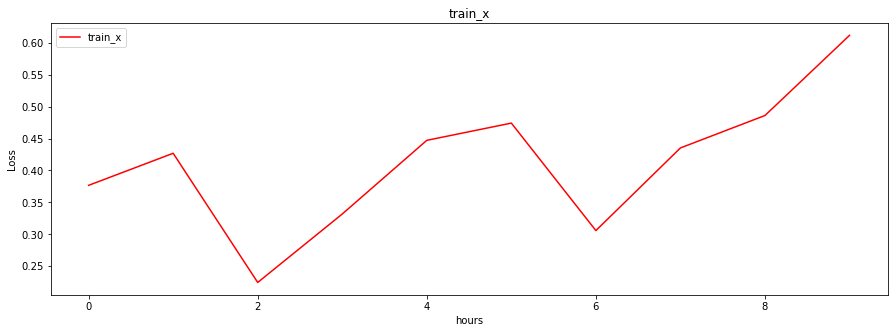

In [710]:
print(data_training_array_scaled.shape)
print(data_training_array_scaled[:10,12])
plt.figure(figsize=(15,5))
plt.plot(data_training_array_scaled[:10,12], color = 'red', label = 'train_x')
plt.title('train_x')
plt.xlabel('hours')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [711]:
data_training_y[:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

### CHART MA's

(3083, 1128)


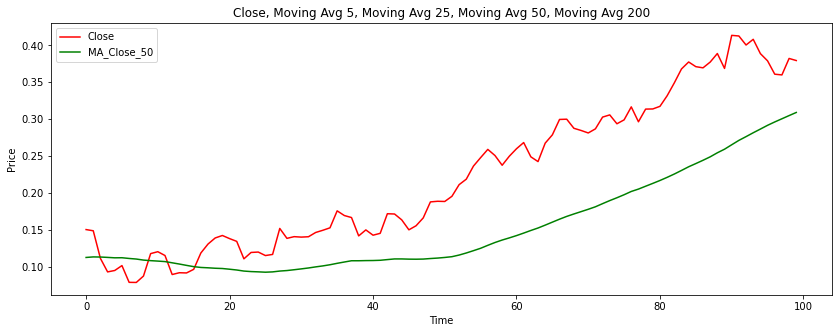

In [712]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
#IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
#IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
#IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
#pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
#pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
#pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3083, 1128)


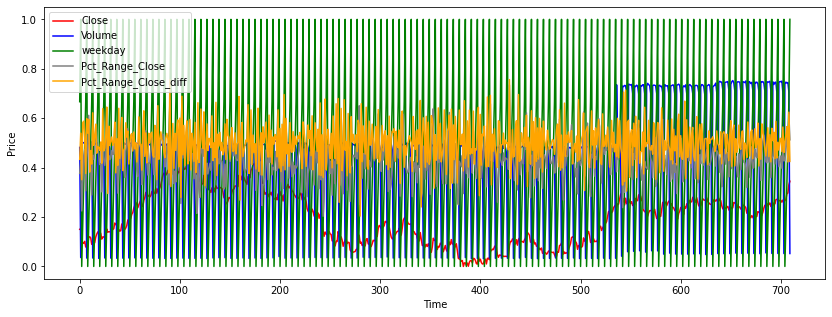

In [713]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(3083, 1128)


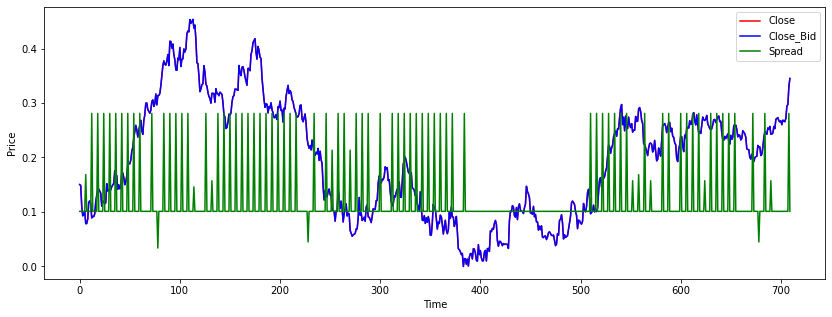

In [714]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [715]:
data_training_array_scaled.shape

(3083, 1128)

In [716]:
data_training_y

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

### Oversampling Inbalanced Class

In [717]:
#oversample = RandomOverSampler(sampling_strategy='minority')
#oversample


In [718]:
#Check Current Shape
print(X_train_np.shape)
print(y_train_np.shape)

(3083, 470)
(3083, 3)


In [719]:
#X_over, y_over = oversample.fit_resample(X_train_np, y_train_np)

### BUILD LSTM MODEL 

In [720]:
X_train_np = x_train 
X_val_np = x_test
y_train_np = y_train
y_val_np = y_test

X_test_np = x_rtest = data_test
y_test_np = y_rtest = data_test_y

In [721]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [722]:
model = Sequential()
model.add(Dense(32, input_dim=X_train_np.shape[1], activation = 'relu'))
model.add(Dense(80, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])

In [723]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 32)                36128     
_________________________________________________________________
dense_48 (Dense)             (None, 80)                2640      
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 243       
Total params: 39,011
Trainable params: 39,011
Non-trainable params: 0
_________________________________________________________________


In [724]:
history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)

Epoch 1/1000
97/97 [==============================] - 0s 4ms/step - loss: 16633253.0000 - acc: 0.3308 - val_loss: 1816694.7500 - val_acc: 0.4187
Epoch 2/1000
97/97 [==============================] - 0s 3ms/step - loss: 3627768.2500 - acc: 0.3435 - val_loss: 7856160.0000 - val_acc: 0.3038
Epoch 3/1000
97/97 [==============================] - 0s 3ms/step - loss: 3435811.5000 - acc: 0.3403 - val_loss: 5579488.0000 - val_acc: 0.4187
Epoch 4/1000
97/97 [==============================] - 0s 3ms/step - loss: 3292729.7500 - acc: 0.3416 - val_loss: 7798644.5000 - val_acc: 0.4187
Epoch 5/1000
97/97 [==============================] - 0s 3ms/step - loss: 2240264.5000 - acc: 0.3377 - val_loss: 1715214.1250 - val_acc: 0.4187
Epoch 6/1000
97/97 [==============================] - 0s 3ms/step - loss: 2922470.0000 - acc: 0.3253 - val_loss: 2347745.0000 - val_acc: 0.3447
Epoch 7/1000
97/97 [==============================] - 0s 3ms/step - loss: 2116443.5000 - acc: 0.3318 - val_loss: 1808779.0000 - val_acc

Epoch 60/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 61/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 62/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 63/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 64/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 65/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 66/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 67/1000
97/97 [==============================] - 0s 3ms/step - 

97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 122/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0860 - val_acc: 0.4187
Epoch 123/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 124/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 125/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 126/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 127/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0868 - val_acc: 0.4187
Epoch 128/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 183/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 184/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0867 - val_acc: 0.4187
Epoch 185/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 186/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 187/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0867 - val_acc: 0.4187
Epoch 188/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 189/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 244/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 245/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 246/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 247/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 248/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0860 - val_acc: 0.4187
Epoch 249/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 250/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 305/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 306/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 307/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0860 - val_acc: 0.4187
Epoch 308/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 309/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 310/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 311/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 366/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 367/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 368/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 369/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 370/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 371/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 372/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0860 - val_acc: 0.4187
Epoch 427/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 428/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0867 - val_acc: 0.4187
Epoch 429/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 430/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 431/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 432/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 433/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 488/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 489/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 490/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 491/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 492/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 493/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 494/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 549/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 550/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 551/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 552/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0868 - val_acc: 0.4187
Epoch 553/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 554/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0867 - val_acc: 0.4187
Epoch 555/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 610/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 611/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 612/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 613/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 614/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 615/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 616/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 671/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 672/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 673/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 674/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 675/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 676/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 677/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

Epoch 731/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 732/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0931 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 733/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 734/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 735/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 736/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 737/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 738/1000
97/97 [==============================] - 0s 3ms

97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 793/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 794/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 795/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 796/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 797/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 798/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 799/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 854/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 855/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0859 - val_acc: 0.4187
Epoch 856/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0860 - val_acc: 0.4187
Epoch 857/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 858/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 859/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0861 - val_acc: 0.4187
Epoch 860/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 915/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0867 - val_acc: 0.4187
Epoch 916/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0867 - val_acc: 0.4187
Epoch 917/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 918/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 919/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0866 - val_acc: 0.4187
Epoch 920/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0867 - val_acc: 0.4187
Epoch 921/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 976/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0862 - val_acc: 0.4187
Epoch 977/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 978/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0929 - acc: 0.3837 - val_loss: 1.0864 - val_acc: 0.4187
Epoch 979/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 980/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0865 - val_acc: 0.4187
Epoch 981/1000
97/97 [==============================] - 0s 3ms/step - loss: 1.0930 - acc: 0.3837 - val_loss: 1.0863 - val_acc: 0.4187
Epoch 982/1000
97/97 [==============================] - 0s 3ms/step - loss: 1

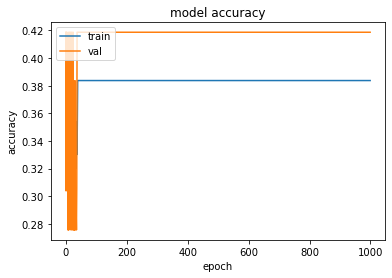

In [725]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [762]:
model.save(source_data_toSave + file_name_toSave)

In [763]:
#Load Model
model = tf.keras.models.load_model(source_data_toSave + file_name_toSave)

In [764]:
def precision(label, confusion_matrix):
    #print('label',label)
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

### CONFUSION MATRIX TEST

In [765]:
#TEST
y_test_pred = model.predict(X_test_np)
print(X_test_np.shape)

print(y_test_pred.shape)
print(y_test_np.shape)

(828, 1128)
(828, 3)
(828, 3)


In [766]:
ID = 4
print(y_test_pred[ID])
print(y_test_np[:ID])

[0.29988796 0.3853232  0.31478876]
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [767]:
uniques_y_test_pred = uniques[y_test_pred.argmax(1)]
uniques_y_test_np = uniques[y_test_np.argmax(1)]
#print(uniques_y_test_pred)
print(uniques_y_test_pred.shape)
#print(uniques_y_test_np)
print(uniques_y_test_np.shape)

(828,)
(828,)


In [768]:
print(uniques)

[-1.  0.  1.]


In [769]:
conf_matrix_test = confusion_matrix(uniques_y_test_np, uniques_y_test_pred)
conf_matrix_test

array([[  0, 207,   0],
       [  0, 422,   0],
       [  0, 199,   0]], dtype=int64)

In [770]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_test):9.3f}    {recall(indx, conf_matrix_test):6.3f}")

indx Value Precision Recall
0
   -1          nan     0.000
1
    0        0.510     1.000
2
    1          nan     0.000


In [771]:
print("precision total:", precision_macro_average(conf_matrix_test))
print("recall total:", recall_macro_average(conf_matrix_test))

precision total: nan
recall total: 0.3333333333333333


In [772]:
accuracy(conf_matrix_test)

0.5096618357487923

### CONFUSION MATRIX TRAIN

In [773]:
#TRAIN
y_train_pred = model.predict(X_train_np)
print(X_train_np.shape)

print(y_train_pred.shape)
print(y_train_np.shape)

(3083, 1128)
(3083, 3)
(3083, 3)


In [774]:
ID = 4
print(y_train_pred[:ID])
print(y_train_np[:ID])

[[0.29988796 0.3853232  0.31478876]
 [0.29988796 0.3853232  0.31478876]
 [0.29988796 0.3853232  0.31478876]
 [0.29988796 0.3853232  0.31478876]]
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [775]:
uniques_y_train_pred = uniques[y_train_pred.argmax(1)]
uniques_y_train_np = uniques[y_train_np.argmax(1)]
print(uniques_y_train_pred)
print(uniques_y_train_pred.shape)
print(uniques_y_train_np)
print(uniques_y_train_np.shape)

[0. 0. 0. ... 0. 0. 0.]
(3083,)
[ 0. -1. -1. ...  0.  0.  0.]
(3083,)


In [776]:
print(uniques)

[-1.  0.  1.]


In [777]:
conf_matrix_train = confusion_matrix(uniques_y_train_np, uniques_y_train_pred)
conf_matrix_train

array([[   0,  926,    0],
       [   0, 1183,    0],
       [   0,  974,    0]], dtype=int64)

In [778]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_train):9.3f}    {recall(indx, conf_matrix_train):6.3f}")

indx Value Precision Recall
0
   -1          nan     0.000
1
    0        0.384     1.000
2
    1          nan     0.000


In [779]:
print("precision total:", precision_macro_average(conf_matrix_train))
print("recall total:", recall_macro_average(conf_matrix_train))

precision total: nan
recall total: 0.3333333333333333


In [780]:
accuracy(conf_matrix_train)

0.3837171586117418

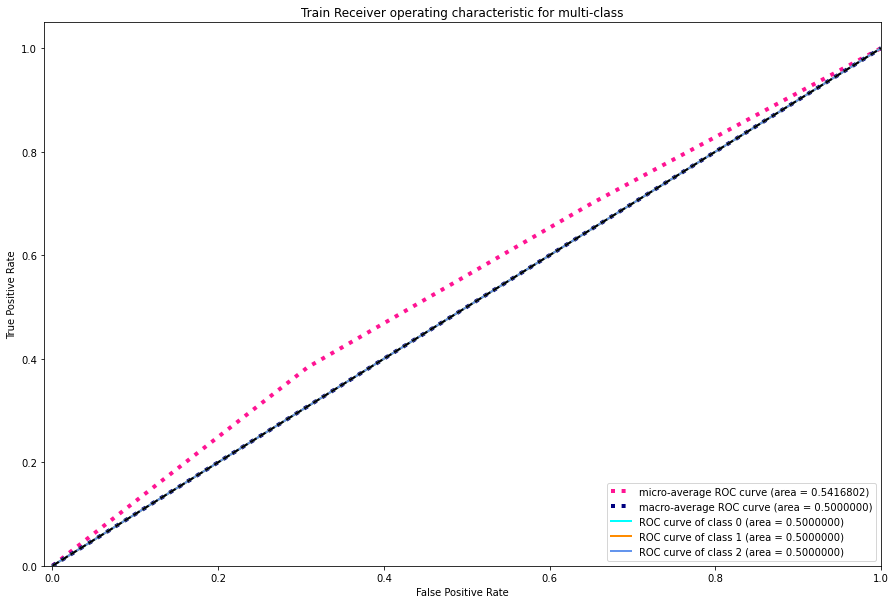

In [781]:
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_train_np.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_train_np[:, i], y_train_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(decodedTestY, decodedTestPredict)
fpr["micro"], tpr["micro"], _ = roc_curve(y_train_np.ravel(), y_train_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_train_np.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_train_np.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_train_np.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=[15,10])
#plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','magenta'])
for i, color in zip(range(y_train_np.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.7f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

### TEST (VAL SubSet) RESULTS TO CSV

In [782]:
print("data_test.shape: ", data_test.shape)


data_test.shape:  (828, 1128)


In [783]:
data_test_res = data_test
data_test_res.reset_index(drop=True, inplace=True)
results_data_test = pd.DataFrame(data_test_res['Open'])
results_data_test['High'] = data_test_res['High']
results_data_test['Low'] = data_test_res['Low']
results_data_test['Close'] = data_test_res['Close']
results_data_test['Volume'] = data_test_res['Volume']
print(results_data_test)

        Open     High      Low    Close       Volume
0    1.17319  1.17438  1.17308  1.17427    8920.6504
1    1.17427  1.17562  1.17198  1.17414  152661.7344
2    1.17412  1.18259  1.17408  1.18138  214738.0938
3    1.18135  1.18694  1.17955  1.18644  216994.3750
4    1.18641  1.18799  1.18254  1.18314  204817.6406
..       ...      ...      ...      ...          ...
823  1.09019  1.09960  1.08970  1.09787  221915.4388
824  1.09788  1.10311  1.09342  1.10169  339215.8879
825  1.10168  1.10937  1.09919  1.10782  290715.4826
826  1.10780  1.11452  1.10702  1.11071  330692.3901
827  1.11213  1.11217  1.11028  1.11158   10126.4174

[828 rows x 5 columns]


In [784]:
uniques_y_test_pred[:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [785]:

uniques_y_test_pred_pd = pd.DataFrame({'Real_Class': uniques_y_test_pred[:]})
print(uniques_y_test_pred_pd)

     Real_Class
0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
..          ...
823         0.0
824         0.0
825         0.0
826         0.0
827         0.0

[828 rows x 1 columns]


In [786]:
results_data_test['Real_Class'] = uniques_y_test_np
results_data_test['Predicted_Class'] = uniques_y_test_pred_pd

In [787]:
results_data_test.head(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.17319,1.17438,1.17308,1.17427,8920.6504,0.0,0.0
1,1.17427,1.17562,1.17198,1.17414,152661.7344,1.0,0.0
2,1.17412,1.18259,1.17408,1.18138,214738.0938,1.0,0.0
3,1.18135,1.18694,1.17955,1.18644,216994.3750,-1.0,0.0
4,1.18641,1.18799,1.18254,1.18314,204817.6406,0.0,0.0
5,1.18314,1.18750,1.18055,1.18223,199182.5000,0.0,0.0
6,1.18150,1.18183,1.18059,1.18149,7389.2700,0.0,0.0
7,1.18149,1.18199,1.17808,1.17948,187651.9063,0.0,0.0
8,1.17946,1.17953,1.17362,1.17716,192445.1250,0.0,0.0
9,1.17712,1.18056,1.17304,1.17946,195770.4844,1.0,0.0


### TRAIN RESULTS TO CSV

### Test Result Save CSV File 

In [788]:
#SAVE
results_data_test.to_csv(test_results_csv, header=True, index=False)

### Test Result Save CSV File 

In [789]:
#SAVE
results_data_test.to_csv(test_results_csv, header=True, index=False)

In [790]:
print("data_train.shape: ", data_training.shape)


data_train.shape:  (3083, 1128)


In [791]:
data_training_res = data_training
data_training_res.reset_index(drop=True, inplace=True)
results_data_train = pd.DataFrame(data_training_res['Open'])
results_data_train['High'] = data_training_res['High']
results_data_train['Low'] = data_training_res['Low']
results_data_train['Close'] = data_training_res['Close']
results_data_train['Volume'] = data_training_res['Volume']
print(results_data_train)
print(results_data_train.shape)
results_data_train = results_data_train.iloc[RANGE:]
results_data_train.reset_index(drop=True, inplace=True)
print(results_data_train.shape)

         Open     High      Low    Close        Volume
0     1.23655  1.23817  1.22801  1.23179  1.078729e+06
1     1.23158  1.23241  1.22967  1.23109  8.212280e+04
2     1.23140  1.23154  1.21310  1.21496  1.130388e+06
3     1.21495  1.21669  1.20594  1.20711  1.123270e+06
4     1.20718  1.21160  1.20519  1.20794  1.118725e+06
...       ...      ...      ...      ...           ...
3078  1.36104  1.36340  1.35645  1.36007  1.962209e+05
3079  1.35912  1.35992  1.35909  1.35914  5.434240e+03
3080  1.35913  1.36137  1.35742  1.36004  2.521172e+05
3081  1.36004  1.36279  1.35836  1.36060  2.456597e+05
3082  1.36060  1.36514  1.36006  1.36282  3.139254e+05

[3083 rows x 5 columns]
(3083, 5)
(3072, 5)


In [792]:
print(uniques_y_train_pred[:])
uniques_y_train_pred.reshape(-1)
print(uniques_y_train_pred.shape)

[0. 0. 0. ... 0. 0. 0.]
(3083,)


In [793]:

uniques_y_train_pred_pd = pd.DataFrame({'Real_Class': uniques_y_train_pred[:]})
print(uniques_y_train_pred_pd)
print(uniques_y_train_pred_pd.shape)


      Real_Class
0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
...          ...
3078         0.0
3079         0.0
3080         0.0
3081         0.0
3082         0.0

[3083 rows x 1 columns]
(3083, 1)


In [794]:
#results_data_train['Real_Class'] = uniques_y_train_np
results_data_train['Predicted_Class'] = uniques_y_train_pred_pd

In [795]:
results_data_train.head(10)
#results_data_train.tail(10)

,Open,High,Low,Close,Volume,Predicted_Class
0,1.21899,1.21999,1.21408,1.21666,1.132577e+06,0.0
1,1.21663,1.21931,1.20414,1.20558,1.063896e+06,0.0
2,1.20628,1.20701,1.20509,1.20662,7.789710e+04,0.0
3,1.20657,1.20802,1.20459,1.20650,1.110041e+06,0.0
4,1.20640,1.21142,1.20518,1.20860,1.116064e+06,0.0
5,1.20851,1.21929,1.20256,1.21814,1.108055e+06,0.0
6,1.21808,1.22491,1.21587,1.22336,1.122153e+06,0.0
7,1.22333,1.23084,1.21984,1.22690,1.056604e+06,0.0
8,1.22640,1.22853,1.22591,1.22834,7.461340e+04,0.0
9,1.22829,1.22875,1.22225,1.22653,1.114383e+06,0.0


In [796]:
uniques_y_train_np[:20]

array([ 0., -1., -1.,  0.,  1., -1.,  0.,  1.,  1.,  0.,  0., -1.,  0.,
        0.,  0.,  1.,  1.,  1.,  0.,  0.])

### Test Result Save CSV File 

In [797]:
#Save
results_data_train.to_csv(train_results_csv, header=True, index=False)